Resources:

- [cifar10 (Colab)](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/cifar10_tutorial.ipynb#scrollTo=ubQdOyR6FjUB)

- [Iterative Pruning (Colab)](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html)

- [Pruning Experiments (Github)](https://github.com/olegpolivin/pruningExperiments/tree/main)
- [Pruning Experiments (Medium)](https://olegpolivin.medium.com/experiments-in-neural-network-pruning-in-pytorch-c18d5b771d6d)
- [Sparsifying Regularizer (Github)](https://github.com/dizam92/pyTorchReg)

Components
- data loading + preprocessing (/utils/data_utils.py ??)

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim


import matplotlib.pyplot as plt
import numpy as np

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# -> /utils/data_utils.py

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:09<00:00, 17577829.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


  cat  ship  deer horse


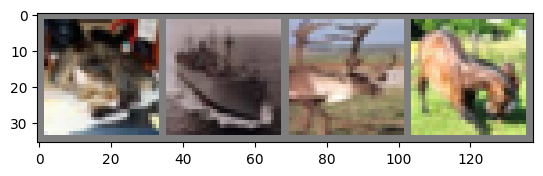

In [8]:
# -> utils/evaluation_utils.py

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [33]:
# -> /models/model.py

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [44]:
# -> utils/training_utils.py
net.to(device)
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # GPU
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.829
[1,  4000] loss: 0.883
[1,  6000] loss: 0.878
[1,  8000] loss: 0.904
[1, 10000] loss: 0.908
[1, 12000] loss: 0.894
[2,  2000] loss: 0.813
[2,  4000] loss: 0.842
[2,  6000] loss: 0.829
[2,  8000] loss: 0.858
[2, 10000] loss: 0.896
[2, 12000] loss: 0.874
[3,  2000] loss: 0.756
[3,  4000] loss: 0.793
[3,  6000] loss: 0.836
[3,  8000] loss: 0.848
[3, 10000] loss: 0.860
[3, 12000] loss: 0.853
[4,  2000] loss: 0.752
[4,  4000] loss: 0.776
[4,  6000] loss: 0.792
[4,  8000] loss: 0.805
[4, 10000] loss: 0.820
[4, 12000] loss: 0.827
[5,  2000] loss: 0.734
[5,  4000] loss: 0.734
[5,  6000] loss: 0.763
[5,  8000] loss: 0.752
[5, 10000] loss: 0.808
[5, 12000] loss: 0.822
[6,  2000] loss: 0.713
[6,  4000] loss: 0.726
[6,  6000] loss: 0.733
[6,  8000] loss: 0.762
[6, 10000] loss: 0.755
[6, 12000] loss: 0.788
[7,  2000] loss: 0.673
[7,  4000] loss: 0.709
[7,  6000] loss: 0.741
[7,  8000] loss: 0.751
[7, 10000] loss: 0.755
[7, 12000] loss: 0.772
[8,  2000] loss: 0.666
[8,  4000] 

GroundTruth:    cat  ship  ship plane


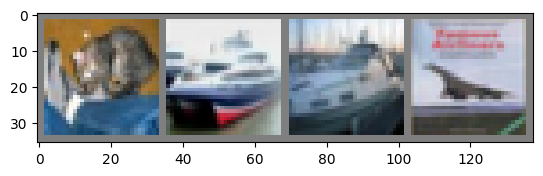

In [45]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [46]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  deer   car plane


In [47]:
# -> utils/evaluation_utils.py

correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [20]:
# -> utils/evaluation_utils.py

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 60 %
Accuracy of  bird : 14 %
Accuracy of   cat : 21 %
Accuracy of  deer : 62 %
Accuracy of   dog : 54 %
Accuracy of  frog : 68 %
Accuracy of horse : 64 %
Accuracy of  ship : 54 %
Accuracy of truck : 65 %
